In [29]:
!pip install tensorflow_hub

In [30]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [31]:
import IPython.display as display
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [32]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [33]:
content_path = './img/inputs/in11.png'
style_path = './img/styles/st11.png'

In [34]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [35]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

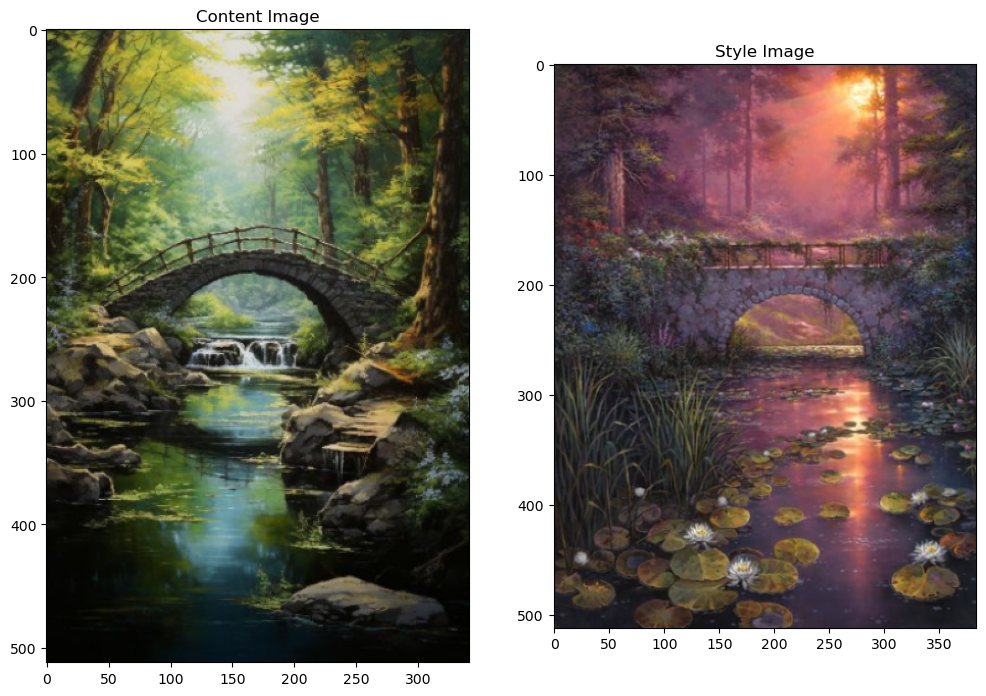

In [36]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

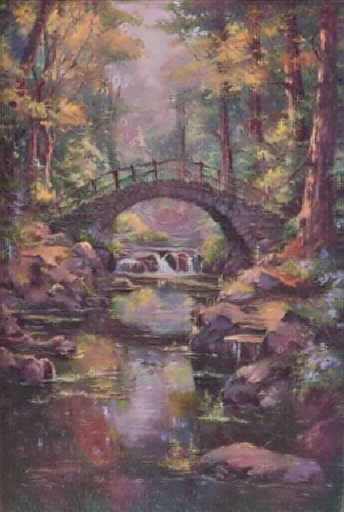

In [37]:
import tensorflow_hub as hub
hub_model = hub.load('https://www.kaggle.com/models/google/arbitrary-image-stylization-v1/frameworks/TensorFlow1/variations/256/versions/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [38]:
import datetime
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Output folder for stylized image
output_folder = './img/output_magenta/'

# Check if the output folder exists, if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Construct the output filename with the timestamp
output_filename = f'stylized_image_{timestamp}.png'
output_path = os.path.join(output_folder, output_filename)

# Save the stylized image
stylized_image = tensor_to_image(stylized_image)
stylized_image.save(output_path)

print(f"Stylized image saved at: {output_path}")

Stylized image saved at: ./img/output_magenta/stylized_image_20240404202042.png


In [39]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [40]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


[('valley', 0.51424354),
 ('American_alligator', 0.10074311),
 ('water_snake', 0.052144405),
 ('viaduct', 0.036228765),
 ('lakeside', 0.03483618)]

In [41]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [42]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [43]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [44]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 384, 64)
  min:  0.0
  max:  801.007
  mean:  19.202589

block2_conv1
  shape:  (1, 256, 192, 128)
  min:  0.0
  max:  2419.8237
  mean:  98.727844

block3_conv1
  shape:  (1, 128, 96, 256)
  min:  0.0
  max:  4457.5127
  mean:  92.476585

block4_conv1
  shape:  (1, 64, 48, 512)
  min:  0.0
  max:  12391.024
  mean:  379.10983

block5_conv1
  shape:  (1, 32, 24, 512)
  min:  0.0
  max:  1573.0247
  mean:  29.911718



In [45]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [46]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [47]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0070298184
    max:  29569.723
    mean:  439.2819

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  71846.875
    mean:  13662.911

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  414135.53
    mean:  11090.261

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5045002.0
    mean:  171074.67

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  73553.84
    mean:  1048.1958

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  918.4482
    mean:  12.307534


In [48]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)


In [49]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [51]:
style_weight=1e-2
content_weight=1e4

In [52]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [53]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

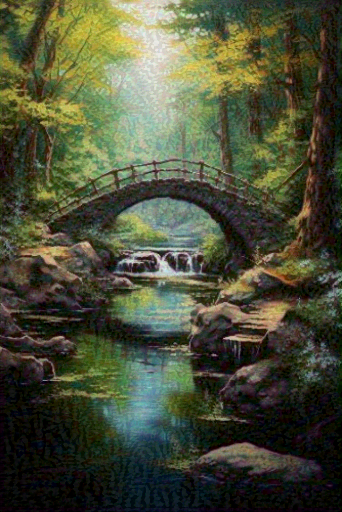

In [54]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

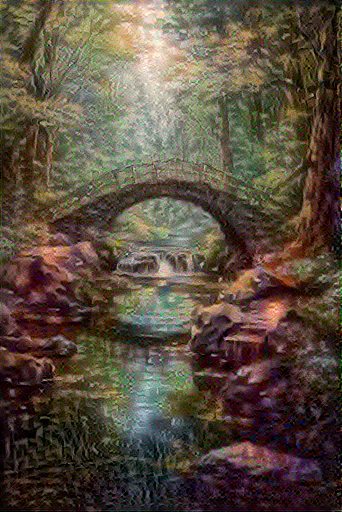

Train step: 100
SSIM: [0.31062222]
PSNR: [18.842304]


In [55]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

    # Calculate SSIM and PSNR
    ssim_val = tf.image.ssim(content_image, image, max_val=1.0)
    psnr_val = tf.image.psnr(content_image, image, max_val=1.0)
    print("SSIM:", ssim_val.numpy())
    print("PSNR:", psnr_val.numpy())

end = time.time()

In [56]:
import datetime
# Convert the generated image tensor to a PIL Image
generated_image_pil = tensor_to_image(image)

# Generate a timestamp for the output filename
timestamp = time.strftime("%Y%m%d%H%M%S")

# Define the output folder and filename
output_folder = './img/final_output/'
output_filename = f'generated_image_{timestamp}.png'
output_path = os.path.join(output_folder, output_filename)

# Save the generated image
generated_image_pil.save(output_path)

print(f"Generated image saved at: {output_path}")

Generated image saved at: ./img/final_output/generated_image_20240404202620.png
